In [2]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [3]:
msft = yf.Ticker('NVDA')

In [4]:
hist = msft.history(period="max")
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22,0.401892,0.448540,0.356440,0.376774,271468800.0,0.0,0.0
1999-01-25,0.406676,0.421029,0.376774,0.416245,51048000.0,0.0,0.0
1999-01-26,0.421029,0.429403,0.377970,0.383951,34320000.0,0.0,0.0
1999-01-27,0.385147,0.394716,0.363616,0.382755,24436800.0,0.0,0.0
1999-01-28,0.382755,0.385147,0.379166,0.381559,22752000.0,0.0,0.0


In [5]:
close = hist.iloc[:,3].to_numpy()

high = hist.iloc[:, 1].to_numpy()
high = np.delete(high, 0)
high = np.append(high, [0])

up = high - close

hist[['Trend_tmr']]='Up'
for i in range(len(close)):
    if up[i]<0:
        hist.iloc[i, -1]='Down'

hist.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
hist.drop(index=hist.iloc[0:4500].index, axis=0, inplace=True)
hist.drop(index='2022-02-16', axis=0, inplace=True)

hist.head()

,Open,High,Low,Close,Trend_tmr
Date,,,,,
2016-12-07,22.908059,23.515060,22.725466,23.458307,Up
2016-12-08,23.487917,23.840767,22.959877,23.065979,Up
2016-12-09,23.243635,23.260907,22.382486,22.656376,Down
2016-12-12,22.170280,22.194954,21.600293,22.106125,Up
2016-12-13,22.229503,22.772349,22.219634,22.495991,Up
2016-12-14,22.834036,23.961673,22.594690,23.798819,Up
2016-12-15,23.909859,24.659973,23.835834,24.356472,Up
2016-12-16,24.632824,24.847493,24.114654,24.775938,Up
2016-12-19,24.600753,25.279310,24.428031,25.076977,Up


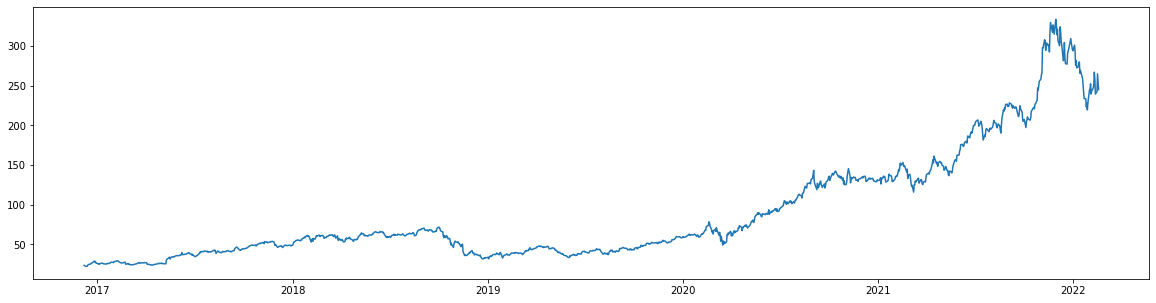

In [6]:
plt.figure(figsize=(20,5))
plt.plot(hist['Close'])

                 Open       High        Low      Close Trend_tmr
Date                                                            
2016-12-08  23.487917  23.840767  22.959877  23.065979        Up
2016-12-09  23.243635  23.260907  22.382486  22.656376      Down
2016-12-29  25.883839  27.509906  25.365670  27.495102        Up
2016-12-30  27.475360  27.616006  26.229285  26.337852      Down
2017-01-09  25.538392  26.648757  25.538392  26.471098        Up
306


Text(0.5, 1.0, 'Simp Close since 2017')

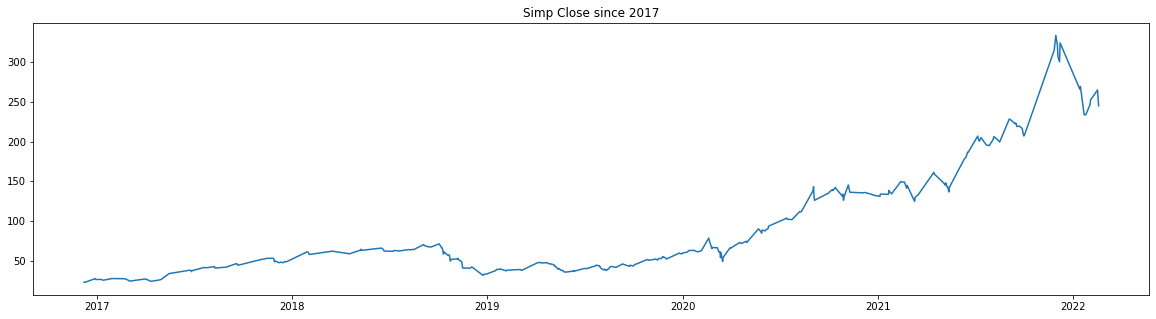

In [7]:
simp = hist.copy(deep=True)
for i in range(len(hist)-1):
    if hist.iloc[i, 4] == hist.iloc[i+1, 4]:
        simp.drop(index=hist.iloc[i: i+1].index, inplace=True)
print(simp.head(5))
print(len(simp))

plt.figure(figsize=(20,5))
plt.plot(simp.iloc[:, 3])
plt.title('Simp Close since 2017')

                Price
Date                 
2016-12-08  22.959877
2016-12-09  23.260907
2016-12-29  25.365670
2016-12-30  27.616006
2017-01-09  25.538392
2017-01-11  26.204612
2017-01-12  25.074504
2017-01-13  25.908512
2017-01-26  26.327982
2017-01-27  27.608605
2017-02-21  26.703037
2017-02-22  27.621213
2017-03-01  24.980149
2017-03-03  24.402027
2017-03-31  26.781212
2017-04-03  27.090032
2017-04-11  23.804146
2017-04-12  24.384739
2017-04-28  25.711446
2017-05-01  26.398266


Text(0.5, 1.0, 'Hybrid since 2017')

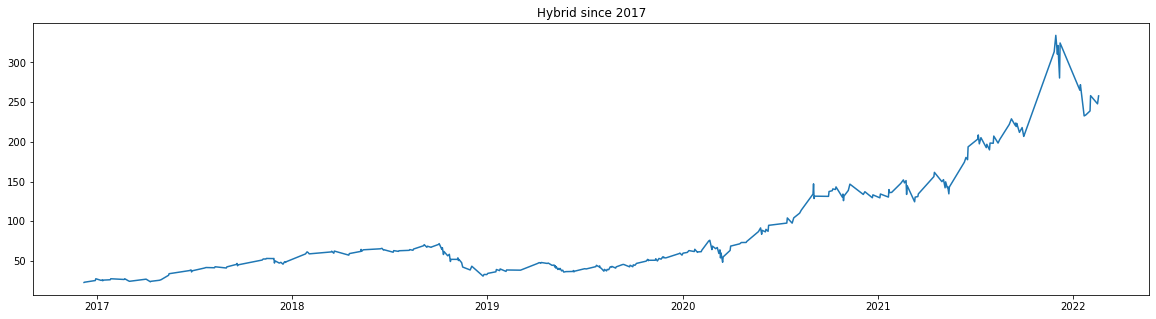

In [8]:
hybrid = simp.copy(deep=True)
hybrid.drop(columns=['Open', 'Close'], inplace=True)
hybrid['Price']=0
for i in hybrid.index:
    if hybrid.loc[i, 'Trend_tmr'] == 'Up':
        hybrid.loc[i, 'Price'] = hybrid.loc[i, 'Low']
    else:
        hybrid.loc[i, 'Price'] = hybrid.loc[i, 'High']

hybrid.drop(columns=['High', 'Low', 'Trend_tmr'], inplace=True)

print(hybrid.head(20))
plt.figure(figsize=(20,5))
plt.plot(hybrid.iloc[:, 0])
plt.title('Hybrid since 2017')


In [9]:
hist['Pivot']=False
for i in hist.index:
    if i in simp.index:
        hist.loc[i, 'Pivot'] = True

print(hist.head())

                 Open       High        Low      Close Trend_tmr  Pivot
Date                                                                   
2016-12-07  22.908059  23.515060  22.725466  23.458307        Up  False
2016-12-08  23.487917  23.840767  22.959877  23.065979        Up   True
2016-12-09  23.243635  23.260907  22.382486  22.656376      Down   True
2016-12-12  22.170280  22.194954  21.600293  22.106125        Up  False
2016-12-13  22.229503  22.772349  22.219634  22.495991        Up  False


In [10]:
data_x = hist[['Open', 'High', 'Low', 'Close']].to_numpy()
data_y = hist[['Pivot']].to_numpy()

scaler = MinMaxScaler(feature_range=(-1, 1))
data_x = scaler.fit_transform(data_x)

train_x = torch.from_numpy(data_x[0:1000, :]).float()
train_y = torch.from_numpy(data_y[0:1000, :]).float()

test_x = torch.from_numpy(data_x[1000:, :]).float()
test_y = torch.from_numpy(data_y[1000:, :]).float()

train_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

batch_size = 10
train_data = DataLoader(train_data, batch_size, shuffle=True)
test_data = DataLoader(test_data, batch_size, shuffle=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
class StockNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [13]:
input_size = 4
output_size = 1
hidden_size = 20
learning_rate = 0.01
num_epoch = 10

model = StockNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epoch):
    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i+1)%100==0:
            print(f'epoch {epoch+1}/{num_epoch}, loss = {loss.item():.10f}')



epoch 1/10, loss = -0.0000000000
epoch 2/10, loss = -0.0000000000
epoch 3/10, loss = -0.0000000000
epoch 4/10, loss = -0.0000000000
epoch 5/10, loss = -0.0000000000
epoch 6/10, loss = -0.0000000000
epoch 7/10, loss = -0.0000000000
epoch 8/10, loss = -0.0000000000
epoch 9/10, loss = -0.0000000000
epoch 10/10, loss = -0.0000000000


In [14]:
with torch.no_grad():
    n_correct=0
    n_samples=0
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        #value, index
        predictions = torch.round(outputs)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')

accuracy = 77.27272727272727


In [15]:
1-train_y.sum()/train_y.shape[0]

tensor(0.7640)